# Tutorial 5a: Model selection I

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t5a_model_selection_1.ipynb).*

In [1]:
import collections
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# The MCMC Hammer
import emcee

# Numerical differentiation package
import numdifftools as ndt

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Model selection for the Good, et al. data

Recall from last time that we were considering two different theoretical models for the spindle length vs. droplet size data presented in Good, et al.

#### Model A

In Model A, the spindle size is independent of droplet size.  The corresponding equation is

\begin{align}
l = \theta.
\end{align}

We assume the data are Gaussian distributed about this $\theta$, which an unknown variance $\sigma$.

#### Model B

We define by Model B the full relation between spindle length and droplet diameter,

\begin{align}
l(d;\gamma,\theta) \approx \frac{\gamma d}{\left(1+(\gamma d/\theta)^3\right)^{\frac{1}{3}}}.
\end{align}

As in Model A, we assume the data are Gaussian distributed about this $\theta$, which an unknown variance $\sigma$.

### The odds ratio
As given in lecture, the odds ratio is

\begin{align}
O_{AB} \approx \left(\frac{P(A\mid I)}{P(B\mid I)}\right)
\left(\frac{P(D\mid \theta^*, \sigma^*, A, I)}{P(D\mid \theta^*, \gamma^*, \sigma^*, B, I)}\right)
\left(\frac{P(\theta^*, \sigma^* \mid A, I) \,2\pi\,\sqrt{\det\boldsymbol{\sigma_A^2}}}
{P(\theta^*, \gamma^*, \sigma^*\mid B, I)\,(2\pi)^{3/2} \sqrt{\det\boldsymbol{\sigma}_B^2}}\right),
\end{align}

where $\boldsymbol{\sigma}_B$ is the covariance matrix computed for Model B.  So, to compute the odds ratio, we need to first specify the prior odds of the two models.  We will assume that

\begin{align}
\frac{P(A\mid I)}{P(B\mid I)} \approx 1,
\end{align}

since we are not sure which model is correct *a priori* (that was the whole purpose of the experiment).  We also need to specify the respective priors.  We will assume that $\theta$, $\gamma$, and $\sigma$ are all independent.  Further, since $\theta$ and $\sigma$ represent the same thing in Model A and in Model B, we assume $P(\theta, \sigma \mid A, I) = P(\theta, \sigma \mid B, I)$.  Finally, we know that $0 \le \gamma \le 1$ by physical considerations.  We will take a uniform prior for $P(\gamma\mid B, I)$, so the ratio

\begin{align}
\frac{P(\theta^*, \sigma^*\mid A, I)}
{P(\theta^*, \gamma^*, \sigma^*\mid B, I)} = 1.
\end{align}

All we have left to do is to compute the MAP and the covariance at the MAP for each model, and then to evaluate the likelihood at the MAP.  So, we will first define the likelihoods for both models.

In <a href="http://bebi103.caltech.edu/2015/tutorials/t3a_regression.html#Parameter-estimation-for-Model-b-(nonlinear-regression)">Tutorial 3a</a>, we found the MAP and covariance for both Model A and Model B.  The problem, though is that we always worked with the marginalized posterior, where $\sigma$, the error in the data, was eliminated from the problem.  Here, we need to find $\sigma^*$, the most probable variance in the data, and use that in computing the (unmarginalized) likelihood.  There is an analytical solution for Model A, but we will just compute both MAPs using `scipy.optimize.minimize()`.  We'll start by defining the functions we need, first for Model A.  Note that our array of parameters, `p`, now has `sigma` in it.  As a reminder, is $l(d;\mathbf{a})$ is the theoretically predicted spindle length for a droplet of diameter $d$ depending on paramters $\mathbf{a}$, the likelihood is

\begin{align}
P(\{d_i, l_i\}\mid \mathbf{a}, M, I) = \prod_i \frac{1}{\sqrt{2\pi \sigma^2}}\,
\exp\left\{-\frac{(l_i - l(d_i, \mathbf{a})^2}{2\sigma^2}\right\}.
\end{align}

In [2]:
def spindle_length(p, d, model):
    """
    Theoretical models for spindle length.
    """
    if model == 'A':
        return p[0] * np.ones_like(d)
    elif model == 'B':
        theta, gamma, _ = p
        return gamma * d / np.cbrt(1 + (gamma * d / theta)**3)
    else:
        raise RuntimeError('Model not properly specified.')

        
def resid(p, d, ell, model):
    """
    Residuals for spindle length model.
    """
    return ell - spindle_length(p, d, model)


def log_likelihood(p, d, ell, model):
    """
    Log likelihood for mitotic spindle length vs droplet size.
    """
    sigma = p[-1]
    
    return -np.sum(resid(p, d, ell, model)**2) / 2 / sigma**2 \
                - len(ell) / 2 * np.log(2 * np.pi * sigma**2)
    
def log_prior(p, model):
    """
    Log prior for mitotic spindle length vs droplet size.
    """
    if (p < 0).any():
        return -np.inf

    if model == 'B' and p[1] > 1:
        return -np.inf

    return -np.log(p[-1])


def log_posterior(p, d, ell, model):
    """
    Log posterior for mitotic spindle length vs droplet size.
    Model A:
        p[0] = theta
        p[1] = sigma
    Model B:
        p[0] = theta
        p[1] = gamma
        p[2] = sigma    
    """
    lp = log_prior(p, model)
    
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood(p, d, ell, model)


def neg_log_posterior(p, d, ell, model):
    return -log_posterior(p, d, ell, model)

We can now proceed with MAP finding using Powell's method.

In [3]:
# Instantiate Hessian for log posterior
hes_fun = ndt.Hessian(log_posterior)

# Load data into DataFrame
df = pd.read_csv('../data/good_et_al/invitro_droplet_data.csv', comment='#')

# Extra arguments as a tuple
args = (df['Droplet Diameter (um)'], df['Spindle Length (um)'])

# Model A
p0 = np.array([50, 5])
args_A = args + ('A',)
res = scipy.optimize.minimize(neg_log_posterior, p0, args=args_A, 
                              method='powell')
popt_A = res.x
hes = hes_fun(popt_A, *args_A)
cov_A = -np.linalg.inv(hes)

# Model B
p0 = np.array([50, 0.5, 5])
args_B = args + ('B',)
res = scipy.optimize.minimize(neg_log_posterior, p0, args=args_B, 
                              method='powell')
popt_B = res.x
hes = hes_fun(popt_B, *args_B)
cov_B = -np.linalg.inv(hes)

Just as a reminder, let's plot our best-fit results.

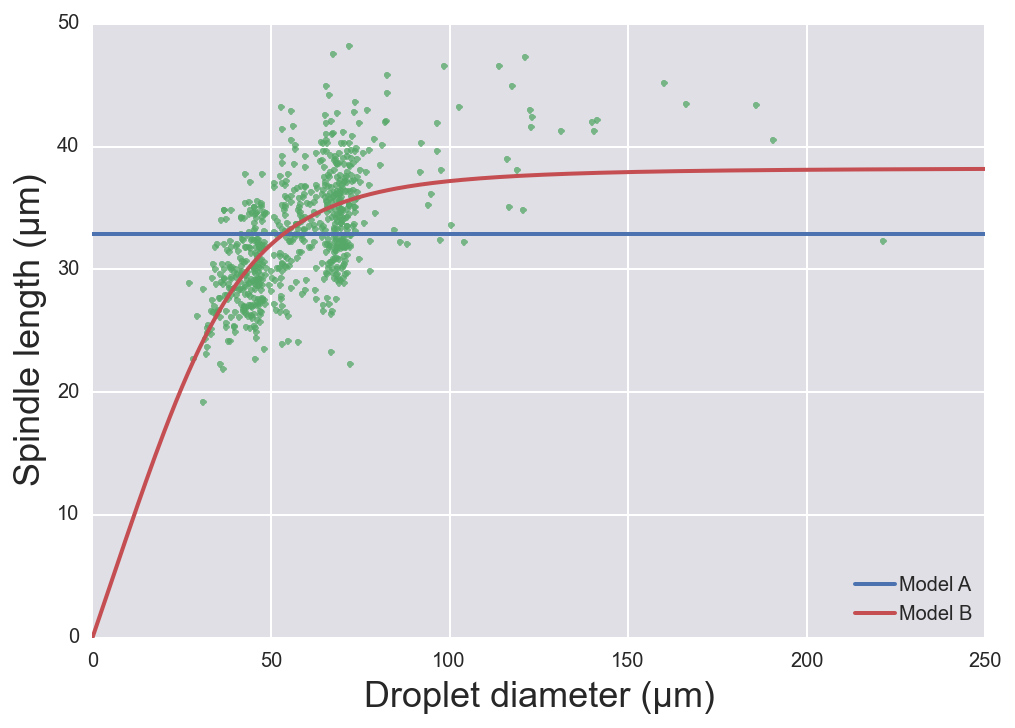

In [4]:
# Smooth droplet diameter for plotting
d_plot = np.linspace(0, 250, 300)

# Plot data and curves
plt.plot(df['Droplet Diameter (um)'], df['Spindle Length (um)'], '.', 
         alpha=0.75, color=sns.color_palette()[1])
plt.plot(d_plot, spindle_length(popt_A, d_plot, 'A'), '-',
         color=sns.color_palette()[0], label='Model A')
plt.plot(d_plot, spindle_length(popt_B, d_plot, 'B'), '-',
        color=sns.color_palette()[2], label='Model B')

# \Labels
plt.xlabel('Droplet diameter (µm)')
plt.ylabel('Spindle length (µm)')
plt.legend(loc='lower right')

We can now compute the components of the odds ratio.  As is often good practice, we will compute the log odds ratio.  We will do it piece by piece.  As we already established, the prior ratio is unity.  Now, let's look at the goodness of fit ratio.

In [5]:
log_good_fit_ratio = log_likelihood(popt_A, *args_A) - \
                                    log_likelihood(popt_B, *args_B)

print('Goodness of fit ratio:', np.exp(log_good_fit_ratio))

Goodness of fit ratio: 3.07815544777e-71


Wow.  Model A really gives a lousy fit to the data compared to model B.  Now, let's see if the Occam factor ratio can overwhelm this bad goodness of fit.  Remember that a model with fewer parameters, like Model A, has a bigger Occam factor, making it more probable.

In [6]:
log_occam_factor = (-np.log(2 * np.pi) + np.log(np.linalg.det(cov_A)) 
                    - np.log(np.linalg.det(cov_B))) / 2

print('Occam factor ratio:', np.exp(log_occam_factor))

Occam factor ratio: 22.4339030418


Yes, the Occam factor penalizes Model B, but nowhere near enough to compensate for the superior goodness of fit it provides.  So, we can compute approximate odds ratio as follows.

In [7]:
log_odds_ratio = log_good_fit_ratio + log_occam_factor

print('Odds ratio:', np.exp(log_odds_ratio))

Odds ratio: 6.90550408627e-70


Ya, Model B is waaaaay more probable than Model A!

## Model selection of the Singer, et al. data
Now, we'll turn to model selection of the Singer, et al. data from [Tutorial 4a](http://bebi103.caltech.edu/2015/tutorials/t4a_param_est_mle.html).  As a reminder, Singer and coworkers used single molecule FISH to get mRNA transcript counts of four different genes in each cell in a population of mouse embryonic stem cells.  The distribution of mRNA counts in a given cell is negative binomially distributed.

\begin{align}
P(n\mid r, p) = \frac{\Gamma(n+r)}{n!\,\Gamma(r)}\,p^{r}(1-p)^{n}.
\end{align}

If there are two different cell types that express the gene differently, the distribution is a linear combination of negative binomials,

\begin{align}
P(n\mid r_1, p_1, r_2, p_2, f) = 
f\,\frac{\Gamma(n+r_1)}{n!\,\Gamma(r_1)!}\,p_1^{r_1}(1-p_1)^{n}
+ (1-f) \frac{\Gamma(n + r_2)}{n!\,\Gamma(r_2)}\,p_2^{r_2}(1-p_2)^{n}.
\end{align}

Out goal here is to decide which of these distributions is more probable for each of the four genes that were measured.  We will define Model A to be a single negative binomial distribution and Model B to be a double negative binomial.  The approximate odds ratio is

\begin{align}
\left(\frac{P(A\mid I)}{P(B\mid I)}\right)
\left(\frac{P(D\mid r^*, p^*, A, I)}{P(D\mid r_1^*, p_1^*, r_2^*, p_2^*, f^*, B, I)}\right)
\left(\frac{P(r^*, p^* \mid A, I) \,2\pi\,\sqrt{\det\boldsymbol{\sigma_A^2}}}
{P(r_1^*, p_1^*, r_2^*, p_2^*, f^*\mid B, I)\,(2\pi)^{5/2} \sqrt{\det\boldsymbol{\sigma}_B^2}}\right).
\end{align}


Since we don't have a preference for either model a priori, we we will take $P(A\mid I) \approx P(B\mid I)$.  We will take uniform priors for $p$, $p_1$, and $p_2$ on the interval $[0,1]$.  Similarly, we will take $f$ to have a uniform prior on $[0,1]$.  We will take uniform priors for $r$, $r_1$, and $r_2$ on the interval $[0, r_\mathrm{max}]$, where $r_\mathrm{max}$ is the most bursts we would expect during an mRNA lifetime.  We will investigate this parameter at the end of our analysis.  For now, we can say that

\begin{align}
\frac{P(r^*, p^* \mid A, I)}{P(r_1^*, p_1^*, r_2^*, p_2^*, f^*\mid B, I)}
= r_\mathrm{max}.
\end{align}

So now, we just need to find the MAPs for each model and evaluate the goodness of fit ratio and the ratio of determinants of the covariances.

For this example, we'll use MCMC to find the MAPs and compute covariances, since the optimization/Hessian calculation is numerically challenging.  We start by coding up the functions we need.

In [8]:
def log_likelihood(params, n, model):
    """
    Log likelihood for negative binomial distributed parameters.
        params = np.array([r_1, p_1, r_2, p_2, f])
    """
    if model == 'A':
        return st.nbinom.logpmf(n, params[0], params[1]).sum()
    elif model == 'B':
        r_1, p_1, r_2, p_2, f = params
        return np.log(f * st.nbinom.pmf(n, r_1, p_1)
                      + (1-f) * st.nbinom.pmf(n, r_2, p_2)).sum()
    else:
        raise RuntimeError('Invalid model.')

        
def log_prior(params, r_max, model):
    """
    Log prior for negative binomially distributed bursty gene expression.
    """
    if (params < 0).any() or params[0] > r_max or params[1] > 1:
        return -np.inf
    
    if model == 'A':
        return -np.log(r_max)
    elif model == 'B':
        r_1, p_1, r_2, p_2, f = params
        if p_1 < p_2 or f > 1 or r_2 > r_max:
            return -np.inf
        return -2 * np.log(r_max)

        
def log_posterior(params, n, r_max, model):
    """
    Log posterior for negative binomials.
    """
    lp = log_prior(params, r_max, model)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood(params, n, model)

We'll write a function to do the MCMC sampling for the respective models.  We will use the `run_ensemble_emcee()` method in the `bebi103` module for convenience.  A nicety with that module is that the traces are conveniently returned as Pandas `DataFrame`s.

In [12]:
def sample_mcmc(n, model, r_max=100, n_walkers=50, n_burn=1000, n_steps=10000, 
                threads=1):
    """
    Sample postrior using MCMC.
    """
    # Arguments for likelihood
    args = (n, r_max, model)
    
    # Parameters and how we start them
    if model == 'A':
        p_dict = collections.OrderedDict(
                [('r', (np.random.exponential, (1,))),
                 ('p', (np.random.uniform, (0, 1)))])
        # Get samples
        return bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps,
                        n_walkers, p_dict=p_dict, args=args, threads=threads)
    elif model == 'B':
        p_dict = collections.OrderedDict(
                [('r1', (np.random.exponential, (1,))),
                 ('p1', (np.random.uniform, (0, 1))),
                 ('r2', (np.random.exponential, (1,))),
                 ('p2', (np.random.uniform, (0, 1))),
                 ('f', (np.random.uniform, (0, 1)))])

        # Build p0; need to make sure p1 > p2
        p0 = np.empty((n_walkers, 5))
        for i, key in enumerate(p_dict):
            p0[:,i] = p_dict[key][0](*(p_dict[key][1] + (n_walkers,)))

        # Make sure p1 > p2
        p0[:,1], p0[:,3] = np.maximum(p0[:,1], p0[:,3]), \
                                np.minimum(p0[:,1], p0[:,3])
    
        return bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps,
                p0=p0, args=args, threads=threads, columns=list(p_dict.keys()))

### Analysis for Rex1
Now, we'll load the data and do the calculation for the Rex1 gene, which we saw displayed qualitatively double-negative binomial behavior.

In [14]:
df = pd.read_csv('../data/singer_et_al/singer_transcript_counts.csv',
                comment='#')

df_A = sample_mcmc(df['Rex1'], 'A', threads=6)
df_B = sample_mcmc(df['Rex1'], 'B', threads=6)

Now that we have the samples, we can pull out the MAP and compute the covariance matrix.  We can then use the MAP to compute the maximum likelihood.  Pulling out the MAPs is as we have done before with MCMC samples.  Note that the `DataFrame` containing the traces has the log posterior as its penultimate column and the chain number its last column, so we ignore those values.

In [19]:
# Pull out MAPs
max_ind = np.argmax(df_A['lnprob'].values)
popt_A = df_A.irow(max_ind).values[:-2]

max_ind = np.argmax(df_B['lnprob'].values)
popt_B = df_B.irow(max_ind).values[:-2]

# Show what we got
print('popt_A', popt_A)
print('popt_B', popt_B)

popt_A [ 1.63251006  0.01166245]
popt_B [ 3.30287917  0.18448576  5.13038124  0.03061542  0.16302928]


Referring back to [Tutorial 4a](t4a_param_est_mle.html), these are the same values we got by optimization for Rex1.  If we are approximating the posterior as Gaussian, we can just directly compute the covariance matrix from the traces.  We can use the `cov()` method of a `DataFrame` to do that.

In [23]:
# Compute covariance
cov_A = df_A.cov().values[:-2,:-2]
cov_B = df_B.cov().values[:-2,:-2]

We now have the pieces in hand to compute the odds ratio.  We'll start with the Occam factor ratio.  We need to specify $r_\mathrm{max}$, the maximum number of bursts in an mRNA lifetime.  We'll take it to be 100 as a large estimate.  Remember, this penalizes the double-negative binomial model.

In [25]:
r_max = 100
log_occam_ratio = np.log(r_max) \
                + np.log(np.linalg.det(cov_A)) / 2 \
                - np.log(np.linalg.det(cov_B)) / 2 \
                - 1.5 * np.log(2 * np.pi)
                         
print('log occam ratio =', log_occam_ratio)

log occam ratio = 4.42170831031


So, the Occam factor penalizes the two-parameter model by a factor of about $\mathrm{e}^4.4 \approx$ 80.  Now, we'll compute the goodness of fit.

In [30]:
log_good_fit_ratio = log_likelihood(popt_A, df['Rex1'], 'A') - \
                                    log_likelihood(popt_B, df['Rex1'], 'B')
    
print('log good fit ratio =', log_good_fit_ratio)

log good fit ratio = -48.3110922478


The goodness of fit overwhelms the Occam factor, and the double negative binomial is far more likely.  Even a large $r_\mathrm{max}$ would not make the Occam factor ratio compete with the goodness of fit.  The final odd ratio is:

In [32]:
print('odds ratio = ', np.exp(log_good_fit_ratio + log_occam_ratio))

odds ratio =  8.69125999435e-20


The double negative binomial is overwhelmingly favored.

### Analysis for Prdm14
We will do the same analysis with Prdm14, which showed qualitatively single negative binomial behavior.

In [33]:
df_A = sample_mcmc(df['Prdm14'], 'A', threads=6)
df_B = sample_mcmc(df['Prdm14'], 'B', threads=6)

We proceed to continue the analysis as for Rex1.

In [36]:
# Pull out MAPs
max_ind = np.argmax(df_A['lnprob'].values)
popt_A = df_A.irow(max_ind).values[:-2]

max_ind = np.argmax(df_B['lnprob'].values)
popt_B = df_B.irow(max_ind).values[:-2]

# Show what we got
print('popt_A', popt_A)
print('popt_B', popt_B)

# Compute covariance
cov_A = df_A.cov().values[:-2,:-2]
cov_B = df_B.cov().values[:-2,:-2]

# Compute log Occam ratio
r_max = 100
log_occam_ratio = np.log(r_max) \
                + np.log(np.linalg.det(cov_A)) / 2 \
                - np.log(np.linalg.det(cov_B)) / 2 \
                - 1.5 * np.log(2 * np.pi)
                         
print('log occam ratio =', log_occam_ratio)

# Goodness of fit ratio
log_good_fit_ratio = log_likelihood(popt_A, df['Prdm14'], 'A') - \
                                    log_likelihood(popt_B, df['Prdm14'], 'B')
    
print('log good fit ratio =', log_good_fit_ratio)

# Put it together
print('odds ratio = ', np.exp(log_good_fit_ratio + log_occam_ratio))

popt_A [ 0.55270768  0.1086294 ]
popt_B [ 76.8987886    0.99556836   1.06776011   0.14573964   0.30029125]
log occam ratio = -0.339403244078
log good fit ratio = -1.35650104409
odds ratio =  0.183433277463


We got the same MAP as in Tutorial 3a for Model A.  But we get a curious feature that the odds ratio is inconclusive; neither model is favored strongly.  Furthermore, the Occam factor ratio slightly favors the mode complicated double negative binomial model, even though we saw in Tutorial 3a that the number of transcripts of Prdm14 was unimodal.  What is up?

To check, let's look at our posteriors, first for model A.

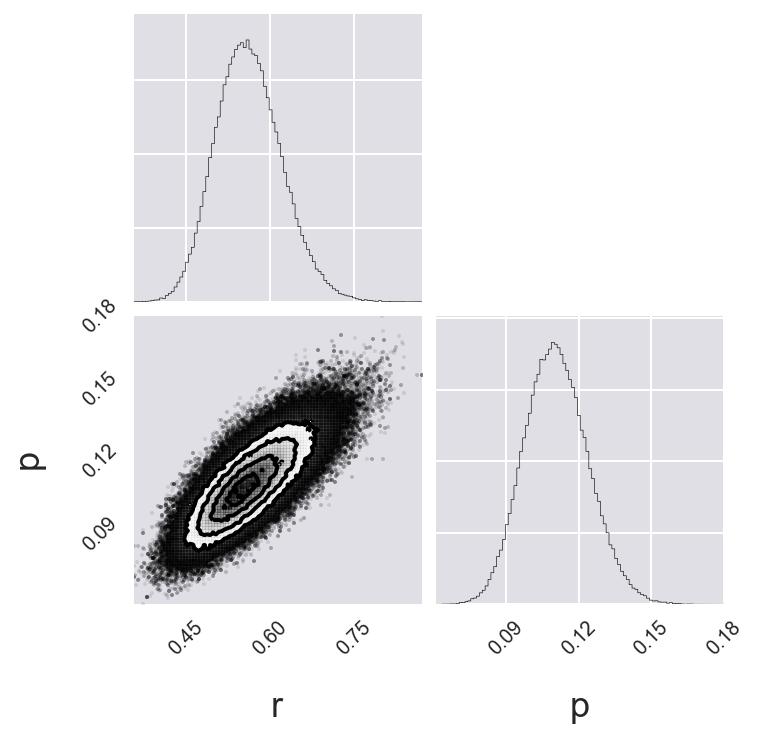

In [37]:
corner.corner(df_A[['r', 'p']], labels=['r', 'p'], bins=100);

This looks ok.  Things look roughly Gaussian.  Now let's look at the posteriors for Model B.

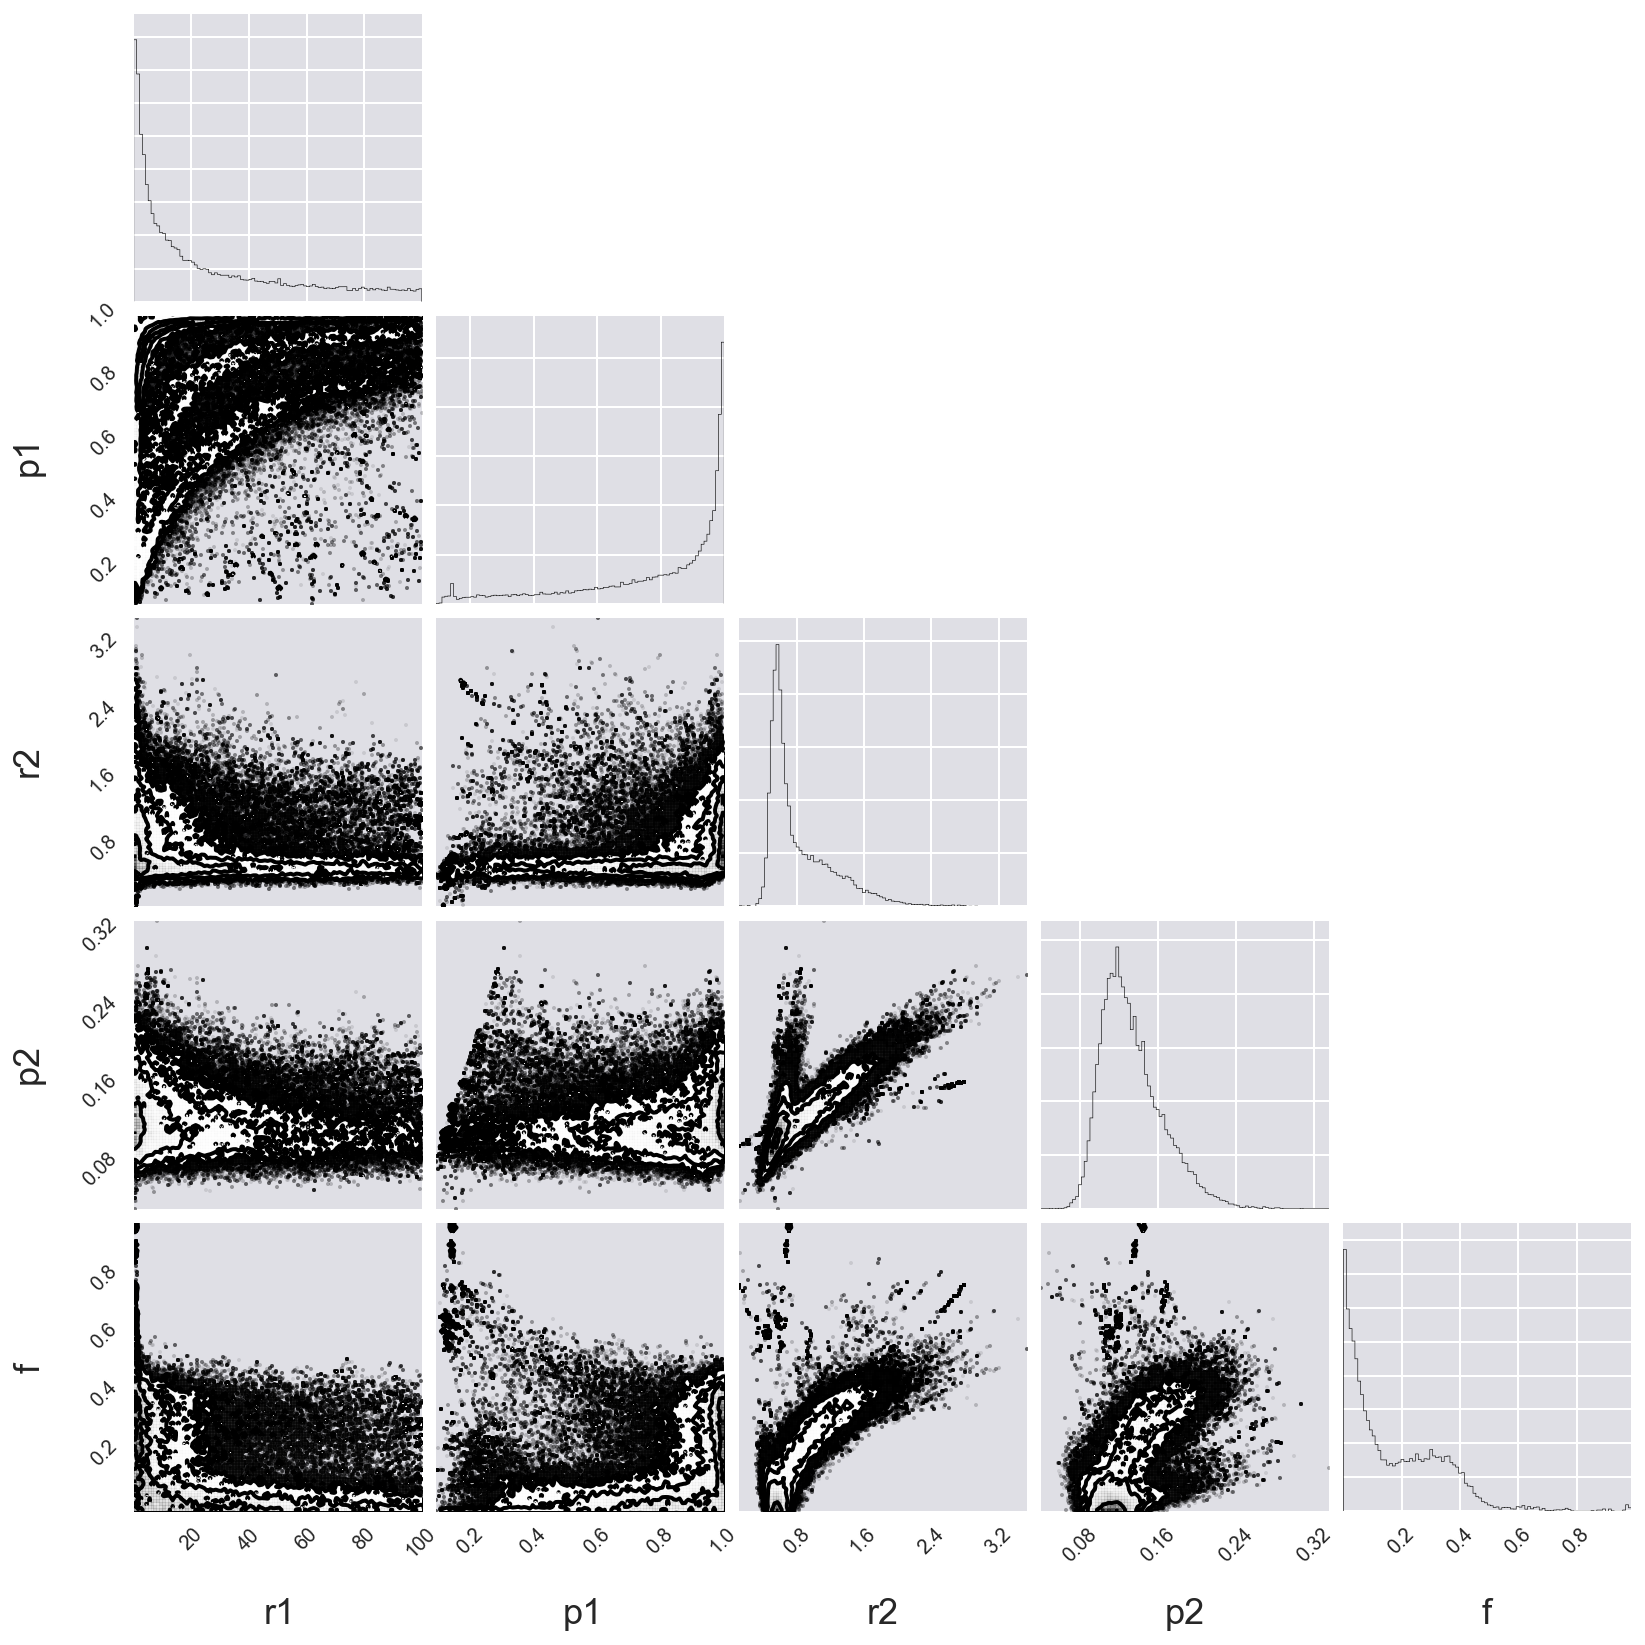

In [38]:
corner.corner(df_B[df_B.columns[:-2]], labels=df_B.columns[:-2], bins=100);

Wow, these things are nowhere near Gaussian.  Therefore, the approximation for the odds ratio breaks down.  We will learn in two weeks' time how to compute the odds ratio using MCMC without approximation.  We will then be able to make the comparison.

In [10]:
def sample_ptmcmc(n, model, r_max=100, n_temps=20, n_walkers=50, n_burn=500, 
                  n_steps=5000, threads=1):
    """
    Sample postrior using PTMCMC.
    """
    # Arguments for posterior
    loglargs = (n, model)
    
    # Arguments for posterior
    logpargs = (r_max, model)
        
    # Parameters and how we start them
    if model == 'A':
        p_dict = collections.OrderedDict(
                [('r', (np.random.exponential, (1,))),
                 ('p', (np.random.uniform, (0, 1)))])
        # Get samples
        return bebi103.run_pt_emcee(log_likelihood, log_prior, n_burn, n_steps,
                        n_temps=20, n_walkers=50, p_dict=p_dict, 
                        loglargs=loglargs, logpargs=logpargs, threads=threads)
    elif model == 'B':
        p_dict = collections.OrderedDict(
                [('r1', (np.random.exponential, (1,))),
                 ('p1', (np.random.uniform, (0, 1))),
                 ('r2', (np.random.exponential, (1,))),
                 ('p2', (np.random.uniform, (0, 1))),
                 ('f', (np.random.uniform, (0, 1)))])

        # Build p0; need to make sure p1 > p2
        p0 = np.empty((n_temps, n_walkers, 5))
        for i, key in enumerate(p_dict):
            p0[:,:,i] = p_dict[key][0](*(p_dict[key][1] + ((n_temps, n_walkers),)))

        # Make sure p1 > p2
        p0[:,1], p0[:,3] = np.maximum(p0[:,1], p0[:,3]), \
                                np.minimum(p0[:,1], p0[:,3])
    
        return bebi103.run_pt_emcee(log_likelihood, log_prior, n_burn, n_steps,
                n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs, 
                threads=threads, columns=list(p_dict.keys()), return_sampler=True)

Now, let's sample the Rex1 data for Model A and Model B.  Of course we start by loading in the data.

In [ ]:
df = pd.read_csv('../data/singer_et_al/singer_transcript_counts.csv',
                comment='#')

df_B, betas_B, lnZ_B, dlnZ_B, sampler = sample_ptmcmc(df['Prdm14'], 'B', threads=6)
df_A, betas_A, lnZ_A, dlnZ_A = sample_ptmcmc(df['Prdm14'], 'A', threads=6)


# df_A = sample_mcmc(df['Rex1'], 'A', threads=6, n_burn=100, n_steps=200)
# df_B = sample_mcmc(df['Rex1'], 'B', threads=6, n_burn=100, n_steps=200)